# 1. Carga de bibliotecas

Seccion para instalar e importar bibliotecas necesarias

In [ ]:
# Acá instalamos la biblioteca fitter para el ajuste de funciones
%pip install fitter

In [8]:
# Acá importarmos todas las bibliotecas necesarias: Pandas, Numpy, Scipy y Fitter
from fitter import Fitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import csv

In [ ]:
# Esto se hace para montar el gogle drive y poder acceder datos alojados allí.
from google.colab import drive
drive.mount('/content/drive')

# 2. Carga de datos





In [9]:
#ESTE ES EL CORRECTO
import re

def parse_csv_line_with_double_quotes(line):
    """
    Parsea líneas con formato: "campo1,""campo con comas, y más texto"",""otro campo""..."
    """
    line = line.strip()

    # Si no está entre comillas exteriores, usar split normal
    if not (line.startswith('"') and line.endswith('"')):
        return [field.strip().strip('"') for field in line.split(',')]

    # Quitar comillas exteriores
    content = line[1:-1]

    fields = []
    current_field = ""
    i = 0

    while i < len(content):
        if content[i:i+2] == '""':
            # Encontramos comillas dobles - inicio de un campo entrecomillado
            i += 2  # Saltar las comillas dobles iniciales
            field_content = ""

            # Buscar el final del campo (comillas dobles seguidas de coma o final)
            while i < len(content):
                if content[i:i+2] == '""':
                    # Encontramos las comillas dobles de cierre
                    if i + 2 >= len(content) or content[i + 2] == ',':
                        # Es el final del campo
                        fields.append(field_content)
                        i += 2  # Saltar las comillas dobles
                        if i < len(content) and content[i] == ',':
                            i += 1  # Saltar la coma
                        current_field = ""
                        break
                    else:
                        # Son comillas literales dentro del campo
                        field_content += '""'
                        i += 2
                else:
                    field_content += content[i]
                    i += 1
            else:
                # Llegamos al final sin encontrar cierre
                fields.append(field_content)
                break
        elif content[i] == ',':
            # Coma separadora simple
            if current_field:
                fields.append(current_field)
                current_field = ""
            i += 1
        else:
            current_field += content[i]
            i += 1

    # Agregar el último campo si existe
    if current_field:
        fields.append(current_field)

    # Limpiar campos: quitar espacios y comillas sueltas
    cleaned_fields = []
    for field in fields:
        field = field.strip()
        # Si el campo está entre comillas simples, quitarlas
        if len(field) >= 2 and field.startswith('"') and field.endswith('"') and field.count('"') == 2:
            field = field[1:-1]
        cleaned_fields.append(field)

    return cleaned_fields

def load_malformed_csv_v2(file_path):
    """
    Versión mejorada para el formato específico del CSV
    """
    print("Leyendo archivo...")

    with open(file_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

    print(f"Total de líneas: {len(lines)}")

    # Procesar header
    header_line = lines[0].strip()
    if header_line.startswith('"') and header_line.endswith('"'):
        headers = parse_csv_line_with_double_quotes(header_line)
    else:
        headers = [h.strip().strip('"') for h in header_line.split(',')]

    print(f"Headers: {len(headers)} columnas")
    print(f"Columnas: {headers}")

    # Procesar primeras líneas para debugging
    print(f"\nAnalizando las primeras 3 líneas de datos...")
    for i in range(1, min(4, len(lines))):
        line = lines[i].strip()
        if not line:
            continue

        print(f"\nLínea {i}:")
        print(f"Raw: {line[:150]}...")

        try:
            fields = parse_csv_line_with_double_quotes(line)
            print(f"Campos parseados: {len(fields)}")

            # Mostrar los primeros campos
            for j, field in enumerate(fields[:8]):
                header_name = headers[j] if j < len(headers) else f"campo_{j}"
                print(f"  {header_name}: {field[:50]}{'...' if len(field) > 50 else ''}")

        except Exception as e:
            print(f"Error: {e}")

    # Procesar todos los datos
    print(f"\nProcesando todas las líneas...")
    all_data = []
    errors = 0

    for line_num in range(1, len(lines)):
        line = lines[line_num].strip()
        if not line:
            continue

        try:
            fields = parse_csv_line_with_double_quotes(line)

            # Ajustar número de campos
            if len(fields) < len(headers):
                fields.extend([''] * (len(headers) - len(fields)))
            elif len(fields) > len(headers):
                fields = fields[:len(headers)]

            all_data.append(fields)

        except Exception as e:
            errors += 1
            if errors <= 5:  # Mostrar solo los primeros 5 errores
                print(f"Error en línea {line_num + 1}: {e}")

    print(f"Líneas procesadas: {len(all_data)}")
    print(f"Errores: {errors}")

    if headers and all_data:
        df = pd.DataFrame(all_data, columns=headers)
        return df
    else:
        return None

# Cargar el archivo
file_path = 'propiedades_redremax_v4_prueba.csv'
print("Procesando CSV con algoritmo mejorado...")
propiedades = load_malformed_csv_v2(file_path)

if propiedades is not None:
    print(f"\n✅ ÉXITO! Shape: {propiedades.shape}")

    print(f"\nPrimera fila verificada:")
    for col in propiedades.columns[:10]:
        value = propiedades.iloc[0][col]
        print(f"{col}: {value}")

    # Verificaciones específicas
    print(f"\nVerificaciones:")
    print(f"ID oficina: {propiedades.iloc[0]['id_oficina']}")
    print(f"Título completo: {propiedades.iloc[0]['titulo']}")
    print(f"Tipo propiedad: {propiedades.iloc[0]['tipo_propiedad']}")
    print(f"Precio USD: {propiedades.iloc[0]['precio_usd']}")
    print(f"Estado: {propiedades.iloc[0]['estado']}")

    # Guardar resultado
    propiedades.to_csv('/tmp/propiedades_v2.csv', index=False)
    print(f"\nArchivo guardado en: /tmp/propiedades_v2.csv")

else:
    print("❌ Falló el procesamiento")

propiedades = pd.read_csv('/tmp/propiedades_v2.csv')

Procesando CSV con algoritmo mejorado...
Leyendo archivo...
Total de líneas: 58994
Headers: 30 columnas
Columnas: ['id_oficina', 'titulo', 'tipo_propiedad', 'precio_usd', 'precio_ars', 'estado', 'fecha_creacion', 'fecha_aprobacion', 'fecha_expiracion', 'fecha_venta', 'precio_venta_USD', 'precio_venta_ARS', 'comision_venta', 'direccion', 'barrio', 'ciudad', 'habitaciones', 'banios', 'living', 'metros_cubiertos', 'metros_totales', 'anio_construccion', 'id_oficina2', 'apt_credit', 'descripcion', 'fecha_historial_reciente', 'precio_historial_reciente_usd', 'historial_precios_completo', 'vistas', 'contactos']

Analizando las primeras 3 líneas de datos...

Línea 1:
Raw: "AR.42.82.193.197,""Vta 3 ambientes, cochera, balcón, Patio, amenities"",""Departamento Estándar"",""249900"",""349860000"",""active"",""2025-09-17 17...
Campos parseados: 30
  id_oficina: AR.42.82.193.197
  titulo: Vta 3 ambientes, cochera, balcón, Patio, amenities
  tipo_propiedad: Departamento Estándar
  precio_usd: 249900

# 3. Análisis Exploratorio de Datos

In [18]:
# Corroboramos que el tipo de dato de la variable "bicis" es un dataframe
type(propiedades)

pandas.core.frame.DataFrame

In [19]:
# Primeras lineas de nuestro dataframe
propiedades.head()

,id_oficina,titulo,tipo_propiedad,precio_usd,precio_ars,estado,fecha_creacion,fecha_aprobacion,fecha_expiracion,fecha_venta,...,fecha_historial_reciente,precio_historial_reciente_usd,historial_precios_completo,vistas,contactos,fecha_creacion_dt,fecha_venta_dt,fecha_expiracion_dt,diferencia_fechas_dt,contactos_por_intervalo_tiempo
0,AR.42.82.193.197,"Vta 3 ambientes, cochera, balcón, Patio, ameni...",Departamento Estándar,249900.0,349860000.0,active,2025-09-17 17:57:52,2025-09-23 18:46:29,2025-12-17,NaN,...,2025-09-23,249900.0,2025-09-23:249900,0.0,0.0,2025-09-17 17:57:52,NaT,2025-12-17,NaN,NaN
1,AR.42.14.122.49,VENTA depto 4amb+depcia+cochera. balcón Flores.,Departamento Estándar,185000.0,259000000.0,active,2025-09-09 20:41:06,2025-09-23 18:45:18,2025-10-22,NaN,...,2025-09-23,185000.0,2025-09-23:185000,0.0,1.0,2025-09-09 20:41:06,NaT,2025-10-22,NaN,NaN
2,AR.42.48.106.117,Venta departamento 2 amb pozo Nuñez Casa Besares,Departamento Estándar,182000.0,254800000.0,active,2025-09-22 18:06:05,2025-09-23 18:15:05,2025-12-22,NaN,...,2025-09-23,182000.0,2025-09-23:182000,0.0,0.0,2025-09-22 18:06:05,NaT,2025-12-22,NaN,NaN
3,AR.42.48.106.116,Venta Monoambiente en pozo Paseo Chacabuco,Departamento Monoambiente,82500.0,115500000.0,active,2025-09-22 16:37:33,2025-09-23 18:15:00,2025-12-14,NaN,...,2025-09-23,82500.0,2025-09-23:82500,0.0,0.0,2025-09-22 16:37:33,NaT,2025-12-14,NaN,NaN
4,AR.42.94.155.143,VENTA MONOAMBIENTE VILLA CRESPO,Departamento Estándar,48600.0,68040000.0,active,2025-09-15 15:49:08,2025-09-23 18:14:01,2026-03-09,NaN,...,2025-09-23,48600.0,2025-09-23:48600,0.0,0.0,2025-09-15 15:49:08,NaT,2026-03-09,NaN,NaN


In [20]:
# Si solo quiero los nombres de las columnas en formato lista
propiedades.columns

Index(['id_oficina', 'titulo', 'tipo_propiedad', 'precio_usd', 'precio_ars',
       'estado', 'fecha_creacion', 'fecha_aprobacion', 'fecha_expiracion',
       'fecha_venta', 'precio_venta_USD', 'precio_venta_ARS', 'comision_venta',
       'direccion', 'barrio', 'ciudad', 'habitaciones', 'banios', 'living',
       'metros_cubiertos', 'metros_totales', 'anio_construccion',
       'id_oficina2', 'apt_credit', 'descripcion', 'fecha_historial_reciente',
       'precio_historial_reciente_usd', 'historial_precios_completo', 'vistas',
       'contactos', 'fecha_creacion_dt', 'fecha_venta_dt',
       'fecha_expiracion_dt', 'diferencia_fechas_dt',
       'contactos_por_intervalo_tiempo'],
      dtype='object')

In [21]:
# Dimensionalidad del dataframe
propiedades.shape

(58993, 35)

In [22]:
# El tipo de dato de cada una de las columnas
# Acá veo que 'duracion_recorrido', 'fecha_origen_recorrido' y 'fecha_destino_recorrido'
# son de tipo object (texto) y no está bueno eso
propiedades.dtypes

id_oficina                                object
titulo                                    object
tipo_propiedad                            object
precio_usd                               float64
precio_ars                               float64
estado                                    object
fecha_creacion                            object
fecha_aprobacion                          object
fecha_expiracion                          object
fecha_venta                               object
precio_venta_USD                         float64
precio_venta_ARS                         float64
comision_venta                           float64
direccion                                 object
barrio                                    object
ciudad                                    object
habitaciones                             float64
banios                                   float64
living                                   float64
metros_cubiertos                         float64
metros_totales      

In [23]:
# FILTRO: Propiedades con fecha de venta y contactos
# Nota: El filtro adicional por diferencia_fechas_dt se hace DESPUÉS de crear esas columnas (celda 16)

propiedades_con_venta = propiedades[
    (propiedades['fecha_venta'].notna()) & (propiedades['contactos'] > 0)
]

print(f"Propiedades con fecha de venta y contactos: {propiedades_con_venta.shape[0]}")

Propiedades con fecha de venta y contactos: 10949


# 4. Preparación de Datos

Si debo modificar una columna, es conveniente crear una nueva y no pisar la original. Lo mismo para los dataframes

In [24]:
# Creo tres nuevas columnas con las fechas con el tipo de dato correcto. La vista propiedades_con_venta tmb agrega las columnas.
propiedades["fecha_creacion_dt"] = pd.to_datetime(propiedades["fecha_creacion"], format="mixed")
propiedades["fecha_venta_dt"] = pd.to_datetime(propiedades["fecha_venta"], format="mixed")
propiedades["fecha_expiracion_dt"] = pd.to_datetime(propiedades["fecha_expiracion"], format="mixed")
propiedades["diferencia_fechas_dt"] = ((propiedades["fecha_venta_dt"] - propiedades["fecha_creacion_dt"]).dt.total_seconds() / 60)
propiedades["contactos_por_intervalo_tiempo"] = (propiedades["diferencia_fechas_dt"] / propiedades["contactos"])

In [25]:
# filtro por diferencia_fechas_dt > 0
# Ya tenemos las columnas, así que podemos filtrar

propiedades_con_venta = propiedades_con_venta[propiedades_con_venta['diferencia_fechas_dt'] > 0]

print(f"Propiedades con fecha de venta, contactos Y diferencia > 0: {propiedades_con_venta.shape[0]}")
propiedades_con_venta.head()

Propiedades con fecha de venta, contactos Y diferencia > 0: 10940


,id_oficina,titulo,tipo_propiedad,precio_usd,precio_ars,estado,fecha_creacion,fecha_aprobacion,fecha_expiracion,fecha_venta,...,fecha_historial_reciente,precio_historial_reciente_usd,historial_precios_completo,vistas,contactos,fecha_creacion_dt,fecha_venta_dt,fecha_expiracion_dt,diferencia_fechas_dt,contactos_por_intervalo_tiempo
2215,AR.42.31.444.22,VENTA DEPARTAMENTO 2 AMBIENTES EN VILLA DEVOTO,Departamento Estándar,130000.0,176150000.0,completed,2025-08-27 17:26:38,2025-08-28 10:43:33,2025-11-27,2025-09-22,...,2025-08-28,130000.0,2025-08-28:130000,415.0,3.0,2025-08-27 17:26:38,2025-09-22,2025-11-27,36393.366667,12131.122222
2696,AR.42.47.189.186,Departamento Venta 2 ambientes Villa Crespo,Departamento Estándar,65000.0,86450000.0,completed,2025-08-21 14:27:12,2025-08-21 18:44:16,2025-12-24,2025-09-04,...,2025-08-21,65000.0,2025-08-21:65000,310.0,2.0,2025-08-21 14:27:12,2025-09-04,2025-12-24,19292.800000,9646.400000
2784,AR.42.173.123.59,Venta Monoambiente con balcón y vista abierta!,Departamento Monoambiente,51000.0,67830000.0,completed,2025-08-18 11:00:29,2025-08-21 10:53:26,2025-11-18,2025-09-12,...,2025-08-21,51000.0,2025-08-21:51000,684.0,6.0,2025-08-18 11:00:29,2025-09-12,2025-11-18,35339.516667,5889.919444
2809,AR.42.6.378.356,Venta 2 Ambientes con Balcón en Belgrano frente,Departamento Estándar,125000.0,165625000.0,completed,2025-08-20 17:28:10,2025-08-20 17:50:18,2025-11-16,2025-09-23,...,2025-08-20,125000.0,2025-08-20:125000,475.0,2.0,2025-08-20 17:28:10,2025-09-23,2025-11-16,47911.833333,23955.916667
2871,AR.42.149.64.77,Depto 2 ambientes Almagro APTO CREDITO,Departamento Estándar,64000.0,85120000.0,completed,2025-08-19 13:48:53,2025-08-20 12:06:44,2025-11-21 00:00:00,2025-09-10 00:00:00,...,2025-08-20 00:00:00,64000.0,2025-08-20 00:00:00:64000,591.0,7.0,2025-08-19 13:48:53,2025-09-10,2025-11-21,30851.116667,4407.302381


## 📊 Análisis de Tiempos entre Visitas/Contactos

En esta sección analizaremos el tiempo promedio (en minutos) entre cada visita/contacto a una propiedad.

**Variable clave:** `contactos_por_intervalo_tiempo` = tiempo_total_hasta_venta / número_de_contactos


In [26]:
# Estadísticos de contactos por intervalo de tiempo para propiedades vendidas
propiedades_con_venta['contactos_por_intervalo_tiempo'].describe()

count     10940.000000
mean      25066.088213
std       38910.574949
min         189.977778
25%        6906.029779
50%       13183.856771
75%       27384.027917
max      928103.816667
Name: contactos_por_intervalo_tiempo, dtype: float64

In [64]:
# filtramos las propiedades vendidas con datos válidos
# Nos quedamos con las que tienen un intervalo razonable (menor a 60 días en minutos)
propiedades_con_venta_dentro_60_dias = propiedades_con_venta[
    propiedades_con_venta['contactos_por_intervalo_tiempo'] < (60 * 24 * 20)  # 60 días en minutos
]

print(f"Total propiedades vendidas con datos válidos: {propiedades_con_venta_dentro_60_dias.shape[0]}")
print(f"\nEstadísticas de tiempo entre contactos (en minutos):")
print(propiedades_con_venta_dentro_60_dias['contactos_por_intervalo_tiempo'].describe())


Total propiedades vendidas con datos válidos: 8375

Estadísticas de tiempo entre contactos (en minutos):
count     8375.000000
mean     11366.676926
std       6951.495953
min        189.977778
25%       5724.782625
50%       9933.779630
75%      15846.616117
max      28710.911905
Name: contactos_por_intervalo_tiempo, dtype: float64


<Figure size 1200x600 with 0 Axes>

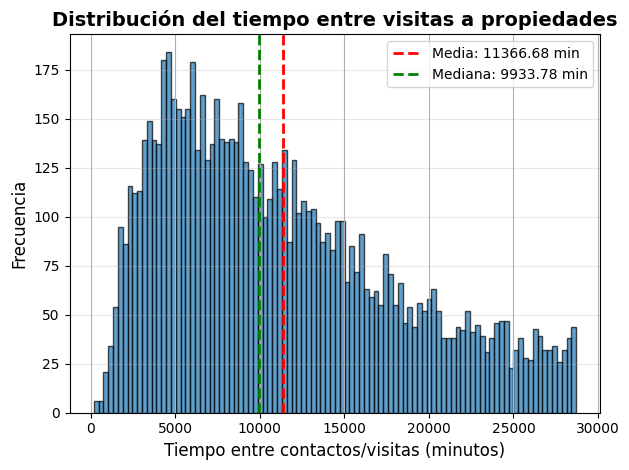


📊 Interpretación:
  - Media: 11366.68 minutos (189.44 horas, 7.89 días)
  - Mediana: 9933.78 minutos (165.56 horas, 6.90 días)


In [65]:
# 📊 HISTOGRAMA: Distribución de tiempos entre visitas/contactos
columna = "contactos_por_intervalo_tiempo"

# Crear figura más grande
plt.figure(figsize=(12, 6))

# Histograma
propiedades_con_venta_dentro_60_dias.hist(columna, bins=100, edgecolor='black', alpha=0.7)

# Calcular y mostrar la media
media = propiedades_con_venta_dentro_60_dias[columna].mean()
mediana = propiedades_con_venta_dentro_60_dias[columna].median()

# Agregar líneas verticales
plt.axvline(media, color="red", linestyle="--", linewidth=2, label=f"Media: {media:.2f} min")
plt.axvline(mediana, color="green", linestyle="--", linewidth=2, label=f"Mediana: {mediana:.2f} min")

# Etiquetas y título
plt.xlabel("Tiempo entre contactos/visitas (minutos)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.title("Distribución del tiempo entre visitas a propiedades", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Interpretación:")
print(f"  - Media: {media:.2f} minutos ({media/60:.2f} horas, {media/1440:.2f} días)")
print(f"  - Mediana: {mediana:.2f} minutos ({mediana/60:.2f} horas, {mediana/1440:.2f} días)")


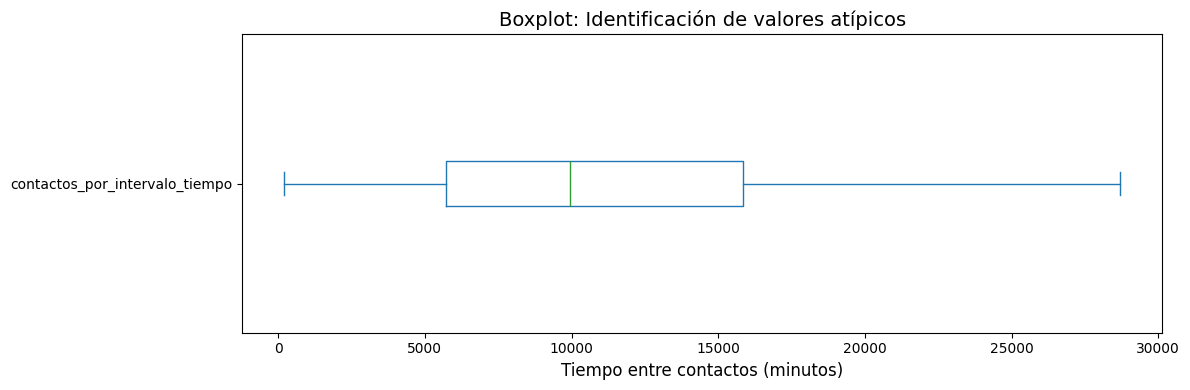

In [66]:
# Boxplot para identificar outliers
plt.figure(figsize=(12, 4))
propiedades_con_venta_dentro_60_dias['contactos_por_intervalo_tiempo'].plot(kind='box', vert=False)
plt.xlabel("Tiempo entre contactos (minutos)", fontsize=12)
plt.title("Boxplot: Identificación de valores atípicos", fontsize=14)
plt.tight_layout()
plt.show()


In [67]:
# Resumen estadístico completo
print("📈 Estadísticas descriptivas de tiempo entre contactos:\n")
print(propiedades_con_venta_dentro_60_dias['contactos_por_intervalo_tiempo'].describe())

# Información adicional
print(f"\n📊 Información adicional:")
print(f"  - Total de registros: {len(propiedades_con_venta_dentro_60_dias)}")
print(f"  - Valores nulos: {propiedades_con_venta_dentro_60_dias['contactos_por_intervalo_tiempo'].isna().sum()}")
print(f"  - Rango: {propiedades_con_venta_dentro_60_dias['contactos_por_intervalo_tiempo'].max() - propiedades_con_venta_dentro_60_dias['contactos_por_intervalo_tiempo'].min():.2f} minutos")

📈 Estadísticas descriptivas de tiempo entre contactos:

count     8375.000000
mean     11366.676926
std       6951.495953
min        189.977778
25%       5724.782625
50%       9933.779630
75%      15846.616117
max      28710.911905
Name: contactos_por_intervalo_tiempo, dtype: float64

📊 Información adicional:
  - Total de registros: 8375
  - Valores nulos: 0
  - Rango: 28520.93 minutos


In [68]:
# Tiempo minimo del dataset
fecha_minima = propiedades_con_venta_dentro_60_dias["fecha_creacion_dt"].min()
print(fecha_minima)

2021-03-19 10:49:49


In [69]:
# Timepo maximo del dataset
fecha_maxima = propiedades_con_venta_dentro_60_dias["fecha_creacion_dt"].max()
print(fecha_maxima)

2025-08-27 17:26:38


In [70]:
# Diferencia entre tiempo minimo y maximo en minutos
diferencia_tiempo = fecha_maxima - fecha_minima
diferencia_minutos = diferencia_tiempo.total_seconds() / 60
print(diferencia_minutos)

2336076.816666667


In [71]:
# Sumatoria de contactos
sumatoria_contactos = propiedades_con_venta_dentro_60_dias["contactos"].sum()
print(sumatoria_contactos)

162285.0


In [72]:
# Sumatoria de vendidos
cantidad_vendidas = (propiedades["estado"] == "completed").sum()
print(cantidad_vendidas)

21583


## 🎯 Ajuste de Distribución para Tiempos entre Contactos

Ahora vamos a ajustar una distribución estadística a nuestros datos de `contactos_por_intervalo_tiempo` usando **Fitter**.


In [73]:
# Preparar Fitter con los datos de tiempo entre contactos
# Eliminamos valores nulos si los hay
datos_tiempo_contactos = propiedades_con_venta_dentro_60_dias['contactos_por_intervalo_tiempo'].dropna()

print(f" Preparando ajuste de distribución...")
print(f"  - Total de datos: {len(datos_tiempo_contactos)}")
print(f"  - Rango: [{datos_tiempo_contactos.min():.2f}, {datos_tiempo_contactos.max():.2f}] minutos")

# Crear el objeto Fitter
fdp_tiempo_contactos = Fitter(datos_tiempo_contactos)
print(f"\n Fitter creado correctamente")


 Preparando ajuste de distribución...
  - Total de datos: 8375
  - Rango: [189.98, 28710.91] minutos

 Fitter creado correctamente


In [74]:
# Ajustar los datos a múltiples distribuciones de SciPy
# Esto puede tardar unos minutos...
print("Ajustando distribuciones... (esto puede tardar un poco)")
fdp_tiempo_contactos.fit()
print("Ajuste completado!")


Ajustando distribuciones... (esto puede tardar un poco)


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Ajuste completado!


2025-09-29 19:21:00.418 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED studentized_range distribution (taking more than 30 seconds)


Top 10 mejores distribuciones ajustadas:



,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
skewnorm,3.199818e-09,2115.650708,2136.749727,0.019119,0.022318,4.687929e-04
triang,3.503376e-09,2095.629765,2116.728784,0.019373,0.025131,4.997510e-05
johnsonsb,3.623826e-09,2100.446033,2128.578058,0.019954,0.021835,6.700500e-04
gausshyper,3.720398e-09,2094.814328,2137.012366,0.018092,0.040223,3.283761e-12
geninvgauss,3.784543e-09,2119.639057,2147.771083,0.023865,0.032714,3.197376e-08
genhyperbolic,4.249185e-09,2126.072809,2161.237841,0.024138,0.030144,4.797840e-07
pearson3,4.475513e-09,2119.734613,2140.833632,0.025501,0.029099,1.355020e-06
gamma,4.475514e-09,2119.734616,2140.833635,0.025501,0.029099,1.355026e-06
erlang,4.475514e-09,2119.734616,2140.833635,0.025501,0.029099,1.355024e-06
f,4.732287e-09,2120.901312,2149.033337,0.027295,0.030541,3.203791e-07


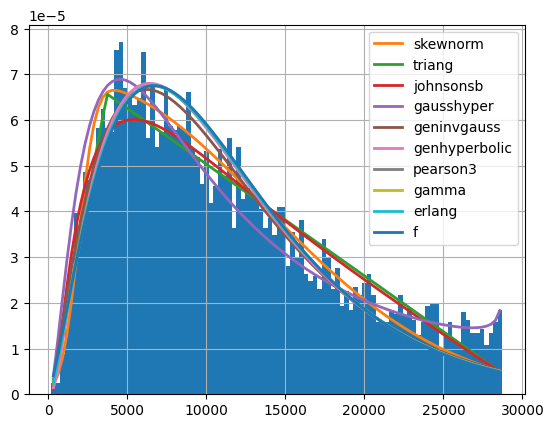

In [75]:
# Ver el resumen de las 10 mejores distribuciones
print("Top 10 mejores distribuciones ajustadas:\n")
fdp_tiempo_contactos.summary(10)


In [76]:
# Obtener la MEJOR distribución según sumsquare_error
# 
# IMPORTANTE: Esta celda te muestra la "mejor" según un criterio automático,
# pero TÚ debes elegir una distribución que sea fácil de invertir.
# Por ejemplo, Wald puede ser compleja de invertir manualmente.
#
# Recomendaciones de distribuciones fáciles de invertir:
# - Exponencial (expon): Muy fácil
# - Uniforme (uniform): Trivial
# - Weibull (weibull_min): Moderada
# - Logística (logistic): Moderada

mejor_distribucion = fdp_tiempo_contactos.get_best(method='sumsquare_error')
print("Mejor distribución encontrada segun sumsquare_error:")
print(mejor_distribucion)

Mejor distribución encontrada segun sumsquare_error:
{'skewnorm': {'a': 13.681217756311524, 'loc': 1929.128868971957, 'scale': 11721.128134950926}}


In [77]:
# ============================================================================
# EXPLORAR DISTRIBUCIONES: Ve los parámetros de cada distribución
# ============================================================================

# Obtener el summary como DataFrame para poder explorarlo
summary_df = fdp_tiempo_contactos.df_errors.sort_values(by='sumsquare_error').head(10)

print("Top 10 distribuciones (ordenadas por mejor ajuste):\n")
print(summary_df)
print("\n" + "="*80)

# Función para ver los parámetros de una distribución específica
def ver_parametros(indice):
    """
    Muestra los parámetros de la distribución en la posición 'indice' (0-9)
    
    Ejemplo: ver_parametros(0) → muestra la mejor distribución
             ver_parametros(1) → muestra la segunda mejor
    """
    if indice < 0 or indice >= len(summary_df):
        print(f"Error: índice {indice} fuera de rango. Usa 0-9")
        return
    
    # Obtener el nombre de la distribución
    nombre_dist = summary_df.index[indice]
    
    # Obtener los parámetros (vienen como tupla)
    parametros_raw = fdp_tiempo_contactos.fitted_param[nombre_dist]
    
    # Obtener la distribución de scipy
    dist_scipy = getattr(stats, nombre_dist)
    
    print(f"\n{'='*80}")
    print(f"Distribución #{indice}: {nombre_dist}")
    print(f"{'='*80}")
    print(f"\nParámetros:\n")
    
    # Convertir tupla a diccionario con nombres apropiados
    if isinstance(parametros_raw, tuple):
        # La mayoría de distribuciones tienen estos parámetros al final
        shapes = parametros_raw[:-2] if len(parametros_raw) > 2 else ()
        loc = parametros_raw[-2] if len(parametros_raw) >= 2 else 0
        scale = parametros_raw[-1] if len(parametros_raw) >= 1 else 1
        
        # Obtener nombres de los parámetros de forma (shape parameters)
        if hasattr(dist_scipy, 'shapes') and dist_scipy.shapes:
            shape_names = dist_scipy.shapes.split(', ')
        else:
            shape_names = []
        
        # Crear diccionario con nombres apropiados
        parametros = {}
        for i, (name, val) in enumerate(zip(shape_names, shapes)):
            parametros[name] = val
        if len(parametros_raw) >= 2:
            parametros['loc'] = loc
        if len(parametros_raw) >= 1:
            parametros['scale'] = scale
    else:
        parametros = parametros_raw
    
    # Mostrar parámetros de forma clara
    for param, valor in parametros.items():
        print(f"   {param:10s} = {valor}")
    
    print(f"\n📝 Código para copiar:\n")
    print(f"   distribucion_elegida = '{nombre_dist}'")
    for param, valor in parametros.items():
        print(f"   {param} = {valor}")
    
    print(f"\n{'='*80}")
    
    return nombre_dist, parametros

Top 10 distribuciones (ordenadas por mejor ajuste):

               sumsquare_error          aic          bic    kl_div  \
skewnorm          3.199818e-09  2115.650708  2136.749727  0.019119   
triang            3.503376e-09  2095.629765  2116.728784  0.019373   
johnsonsb         3.623826e-09  2100.446033  2128.578058  0.019954   
gausshyper        3.720398e-09  2094.814328  2137.012366  0.018092   
geninvgauss       3.784543e-09  2119.639057  2147.771083  0.023865   
genhyperbolic     4.249185e-09  2126.072809  2161.237841  0.024138   
pearson3          4.475513e-09  2119.734613  2140.833632  0.025501   
gamma             4.475514e-09  2119.734616  2140.833635  0.025501   
erlang            4.475514e-09  2119.734616  2140.833635  0.025501   
f                 4.732287e-09  2120.901312  2149.033337  0.027295   

               ks_statistic     ks_pvalue  
skewnorm           0.022318  4.687929e-04  
triang             0.025131  4.997510e-05  
johnsonsb          0.021835  6.700500e-04  


In [79]:
# EJEMPLO: Ver los parámetros de diferentes distribuciones
# 
# Cambia el número (0-9) para explorar diferentes distribuciones:

# Ver la mejor distribución (índice 0)
ver_parametros(1)



Distribución #1: triang

Parámetros:

   c          = 0.11683330812731067
   loc        = 169.04207586301385
   scale      = 30433.163765426078

📝 Código para copiar:

   distribucion_elegida = 'triang'
   c = 0.11683330812731067
   loc = 169.04207586301385
   scale = 30433.163765426078



('triang',
 {'c': 0.11683330812731067,
  'loc': 169.04207586301385,
  'scale': 30433.163765426078})

---
---
# 🎯 Implementa tu inverse sampling aquí

Después de revisar las top 10 distribuciones, elige una y guarda sus parámetros abajo.  
Luego implementa tu método de inverse sampling a mano.

In [81]:
# PASO 1: Guarda los parámetros de la distribución que elegiste
# 
# Ejemplo para distribución F (reemplaza con tu elección):
distribucion_elegida = 'triang'
c = 0.11683330812731067
loc = 169.04207586301385
scale = 30433.163765426078

In [83]:
# PASO 2: INVERSE SAMPLING
#
# Aquí debes:
# 1. Invertir la CDF de la distribución que elegiste
# 2. Generar números aleatorios uniformes U ~ Uniform(0,1)
# 3. Aplicar la función inversa: X = F^(-1)(U)
#
# Ejemplo básico (reemplaza con tu implementación):

# Generar muestras usando el método de scipy como referencia
# (implementar la inversa a mano)
fdp_f = stats.triang.rvs(c, loc=loc, scale=scale, size=20000)

print(f"Muestras generadas: {len(fdp_f)}")
print(f"Estadísticas de las muestras:")
print(f"   Media: {fdp_f.mean():.2f} minutos")
print(f"   Desv. Est.: {fdp_f.std():.2f}")

Muestras generadas: 20000
Estadísticas de las muestras:
   Media: 11403.27 minutos
   Desv. Est.: 6751.53


---
---
## 🔥 ANÁLISIS CRÍTICO: Ocupación del Sistema

**IMPORTANTE:** El tiempo entre visitas POR PROPIEDAD (ej: 7 días) NO es lo mismo que el tiempo entre visitas AL SISTEMA.

Si tienes 20,000 propiedades activas y cada una recibe visitas cada 7 días:
- El SISTEMA recibe visitas mucho más frecuentemente
- Necesitas saber cuántas propiedades están activas simultáneamente


In [84]:
# 📊 PASO 1: Calcular cuántas propiedades hay activas simultáneamente
# =========================================================================

# Necesitamos las fechas de todas las propiedades (vendidas y no vendidas)
# Para cada día, contar cuántas propiedades están "activas" (publicadas pero no vendidas aún)

print("📈 Calculando ocupación del sistema...")
print("="*80)

# Obtener rango de fechas
fecha_min = propiedades['fecha_creacion_dt'].min()
fecha_max = propiedades['fecha_venta_dt'].max()

# Si hay NaT (propiedades no vendidas), usar fecha actual o fecha_expiracion
if pd.isna(fecha_max):
    fecha_max = propiedades['fecha_expiracion_dt'].max()

print(f"\n📅 Período de análisis:")
print(f"  Desde: {fecha_min.date()}")
print(f"  Hasta: {fecha_max.date()}")
print(f"  Duración: {(fecha_max - fecha_min).days} días")

# Crear un rango de fechas para analizar (por ejemplo, cada día)
fechas_analisis = pd.date_range(start=fecha_min, end=fecha_max, freq='D')

print(f"\n🔍 Analizando {len(fechas_analisis)} días...")
print("(Esto puede tardar un momento...)")


📈 Calculando ocupación del sistema...

📅 Período de análisis:
  Desde: 2019-06-25
  Hasta: 2025-09-23
  Duración: 2282 días

🔍 Analizando 2283 días...
(Esto puede tardar un momento...)


In [85]:
# 📊 PASO 2: Contar propiedades activas por día
# =========================================================================

ocupacion = []

# Para cada fecha, contar cuántas propiedades están activas
for fecha in fechas_analisis[::7]:  # Cada 7 días para acelerar (puedes cambiar a ::1 para cada día)
    # Una propiedad está activa si:
    # - Ya fue creada (fecha >= fecha_creacion)
    # - Aún no fue vendida (fecha < fecha_venta) o no tiene fecha de venta
    
    activas = propiedades[
        (propiedades['fecha_creacion_dt'] <= fecha) & 
        ((propiedades['fecha_venta_dt'] > fecha) | (propiedades['fecha_venta_dt'].isna()))
    ]
    
    ocupacion.append({
        'fecha': fecha,
        'propiedades_activas': len(activas)
    })

ocupacion_df = pd.DataFrame(ocupacion)

print("✅ Cálculo completado!")
print(f"\n📊 Estadísticas de ocupación:")
print(f"  Promedio de propiedades activas: {ocupacion_df['propiedades_activas'].mean():.0f}")
print(f"  Máximo de propiedades activas: {ocupacion_df['propiedades_activas'].max():.0f}")
print(f"  Mínimo de propiedades activas: {ocupacion_df['propiedades_activas'].min():.0f}")
print(f"  Mediana: {ocupacion_df['propiedades_activas'].median():.0f}")


✅ Cálculo completado!

📊 Estadísticas de ocupación:
  Promedio de propiedades activas: 9537
  Máximo de propiedades activas: 37396
  Mínimo de propiedades activas: 1
  Mediana: 3996


In [86]:
# 🎯 PASO 3: Calcular tasa de llegada de visitas AL SISTEMA
# =========================================================================

print("\n" + "="*80)
print("🔥 ANÁLISIS CRÍTICO: Diferencia entre visitas por propiedad vs al sistema")
print("="*80)

# Tiempo promedio entre visitas POR PROPIEDAD (ya lo calculamos)
tiempo_entre_visitas_prop = datos_tiempo_contactos.mean()
propiedades_activas_promedio = ocupacion_df['propiedades_activas'].mean()

print(f"\n📊 DATOS CLAVE:")
print(f"  1️⃣  Tiempo entre visitas POR PROPIEDAD:")
print(f"      → {tiempo_entre_visitas_prop:.0f} minutos")
print(f"      → {tiempo_entre_visitas_prop/60:.1f} horas")
print(f"      → {tiempo_entre_visitas_prop/1440:.1f} días")

print(f"\n  2️⃣  Propiedades activas simultáneamente:")
print(f"      → Promedio: {propiedades_activas_promedio:.0f} propiedades")

# CÁLCULO CLAVE: Tasa de llegada al sistema
# Si cada propiedad recibe visitas cada T minutos, y hay N propiedades activas:
# El sistema recibe visitas cada T/N minutos

tiempo_entre_visitas_sistema = tiempo_entre_visitas_prop / propiedades_activas_promedio

print(f"\n  3️⃣  Tiempo entre visitas AL SISTEMA COMPLETO:")
print(f"      → {tiempo_entre_visitas_sistema:.2f} minutos")
print(f"      → {tiempo_entre_visitas_sistema/60:.2f} horas")
print(f"      → {tiempo_entre_visitas_sistema*60:.0f} segundos")

visitas_por_dia_sistema = 1440 / tiempo_entre_visitas_sistema  # 1440 min = 1 día

print(f"\n  4️⃣  Visitas que recibe el SISTEMA por día:")
print(f"      → {visitas_por_dia_sistema:.0f} visitas/día")

print("\n" + "="*80)
print("💡 CONCLUSIÓN:")
print("="*80)
print(f"Aunque CADA PROPIEDAD recibe visitas cada {tiempo_entre_visitas_prop/1440:.1f} días,")
print(f"el SISTEMA COMPLETO recibe visitas cada {tiempo_entre_visitas_sistema:.2f} minutos")
print(f"porque hay {propiedades_activas_promedio:.0f} propiedades activas simultáneamente.")
print("="*80)



🔥 ANÁLISIS CRÍTICO: Diferencia entre visitas por propiedad vs al sistema

📊 DATOS CLAVE:
  1️⃣  Tiempo entre visitas POR PROPIEDAD:
      → 11367 minutos
      → 189.4 horas
      → 7.9 días

  2️⃣  Propiedades activas simultáneamente:
      → Promedio: 9537 propiedades

  3️⃣  Tiempo entre visitas AL SISTEMA COMPLETO:
      → 1.19 minutos
      → 0.02 horas
      → 72 segundos

  4️⃣  Visitas que recibe el SISTEMA por día:
      → 1208 visitas/día

💡 CONCLUSIÓN:
Aunque CADA PROPIEDAD recibe visitas cada 7.9 días,
el SISTEMA COMPLETO recibe visitas cada 1.19 minutos
porque hay 9537 propiedades activas simultáneamente.


## 🎓 Resumen para tu Simulación

### **Dos conceptos diferentes:**

#### 1️⃣ **Tiempo entre visitas POR PROPIEDAD** (~7 días)
- Lo que calculamos con el histograma
- Es el tiempo promedio que pasa entre cada visita **a una propiedad específica**
- **Uso en simulación:** Para generar cuándo llega la próxima visita a UNA propiedad

#### 2️⃣ **Tiempo entre visitas AL SISTEMA** (mucho menor)
- El tiempo entre visitas considerando TODAS las propiedades activas
- **Fórmula:** `tiempo_sistema = tiempo_por_propiedad / num_propiedades_activas`
- **Uso en simulación:** Para generar cuándo llega la próxima visita AL SISTEMA COMPLETO

---

### 💡 **Ejemplo conceptual:**

Imagina un restaurante con 100 mesas:
- **Por mesa:** En promedio, un cliente nuevo cada 2 horas
- **Por restaurante:** Llegan clientes cada (2 horas / 100 mesas) = 1.2 minutos

**Lo mismo pasa con tus propiedades:**
- **Por propiedad:** Una visita cada 7 días
- **Por sistema:** Una visita cada (7 días / N propiedades) = X minutos

---

### 📝 **Para tu simulación necesitas:**

```python
# Variable 1: Distribución de tiempo entre visitas por propiedad
# → Usas la distribución ajustada (ej: Wald, lognorm, etc.)

# Variable 2: Número de propiedades activas simultáneamente  
# → Usas el promedio calculado arriba

# Para generar llegadas de visitas al sistema:
tiempo_llegada_sistema = tiempo_por_propiedad / num_propiedades_activas
```


In [87]:
# 🎯 EJEMPLO NUMÉRICO CONCRETO para aclarar el concepto
# =========================================================================

print("\n" + "="*80)
print("🎓 EJEMPLO DIDÁCTICO")
print("="*80)

print("\n📖 Escenario simplificado:")
print("  - Tienes 100 propiedades activas")
print("  - Cada propiedad recibe visitas cada 10 días (14,400 minutos)")
print()

# Caso 1: Visitas POR PROPIEDAD
print("❓ Pregunta 1: ¿Cuándo llega la próxima visita a la PROPIEDAD #7?")
print("   Respuesta: En promedio, dentro de 10 días")
print()

# Caso 2: Visitas AL SISTEMA
print("❓ Pregunta 2: ¿Cuándo llega la próxima visita al SISTEMA?")
print("   (es decir, a cualquiera de las 100 propiedades)")
print()
print("   Cálculo:")
print("   - Tiempo por propiedad: 10 días = 14,400 minutos")
print("   - Propiedades activas: 100")
print("   - Tiempo entre visitas al sistema: 14,400 / 100 = 144 minutos")
print()
print("   Respuesta: Cada 144 minutos (2.4 horas) llega UNA visita al sistema")
print()

print("💡 En 10 días:")
print(f"   - Cada propiedad individual: recibe 1 visita")
print(f"   - El sistema completo: recibe 100 visitas (1 por cada propiedad)")
print()

print("="*80)
print("🎯 PARA TU SIMULACIÓN:")
print("="*80)
print("Si simulas el sistema completo, debes usar:")
print(f"  → Tasa de llegada: {tiempo_entre_visitas_sistema:.2f} minutos entre visitas")
print(f"  → NO uses {tiempo_entre_visitas_prop:.0f} minutos (ese es por propiedad)")
print("="*80)



🎓 EJEMPLO DIDÁCTICO

📖 Escenario simplificado:
  - Tienes 100 propiedades activas
  - Cada propiedad recibe visitas cada 10 días (14,400 minutos)

❓ Pregunta 1: ¿Cuándo llega la próxima visita a la PROPIEDAD #7?
   Respuesta: En promedio, dentro de 10 días

❓ Pregunta 2: ¿Cuándo llega la próxima visita al SISTEMA?
   (es decir, a cualquiera de las 100 propiedades)

   Cálculo:
   - Tiempo por propiedad: 10 días = 14,400 minutos
   - Propiedades activas: 100
   - Tiempo entre visitas al sistema: 14,400 / 100 = 144 minutos

   Respuesta: Cada 144 minutos (2.4 horas) llega UNA visita al sistema

💡 En 10 días:
   - Cada propiedad individual: recibe 1 visita
   - El sistema completo: recibe 100 visitas (1 por cada propiedad)

🎯 PARA TU SIMULACIÓN:
Si simulas el sistema completo, debes usar:
  → Tasa de llegada: 1.19 minutos entre visitas
  → NO uses 11367 minutos (ese es por propiedad)


---
---

# 📊 ANÁLISIS DE PROBABILIDAD DE VENTA

¿Qué tan probable es que una propiedad se venda?


In [88]:
# 📊 PROBABILIDAD DE VENTA: Análisis completo
# =========================================================================

print("="*80)
print("📊 ANÁLISIS DE VENTAS")
print("="*80)

# Total de propiedades
total_propiedades = len(propiedades)

# Propiedades con fecha de venta
propiedades_vendidas = propiedades['fecha_venta'].notna().sum()
propiedades_no_vendidas = propiedades['fecha_venta'].isna().sum()

# Porcentajes
porcentaje_vendidas = (propiedades_vendidas / total_propiedades) * 100
porcentaje_no_vendidas = (propiedades_no_vendidas / total_propiedades) * 100

print(f"\n📈 ESTADÍSTICAS GENERALES:")
print(f"  • Total de propiedades: {total_propiedades:,}")
print(f"  • Propiedades vendidas: {propiedades_vendidas:,} ({porcentaje_vendidas:.2f}%)")
print(f"  • Propiedades NO vendidas: {propiedades_no_vendidas:,} ({porcentaje_no_vendidas:.2f}%)")

print(f"\n🎯 PROBABILIDAD DE VENTA:")
print(f"  • P(Venta) = {porcentaje_vendidas:.2f}% = {porcentaje_vendidas/100:.4f}")
print(f"  • P(No Venta) = {porcentaje_no_vendidas:.2f}% = {porcentaje_no_vendidas/100:.4f}")

# Análisis adicional: ventas por estado
print(f"\n📊 ANÁLISIS POR ESTADO DE VENTA:")
print("-" * 80)

# Propiedades con fecha de venta Y expiración
vendidas_antes_expiracion = propiedades[
    (propiedades['fecha_venta'].notna()) & 
    (propiedades['fecha_venta'] <= propiedades['fecha_expiracion'])
].shape[0]

# Propiedades que expiraron sin vender
expiradas_sin_venta = propiedades[
    (propiedades['fecha_venta'].isna()) & 
    (propiedades['fecha_expiracion'].notna())
].shape[0]

print(f"  • Vendidas antes de expirar: {vendidas_antes_expiracion:,}")
print(f"  • Expiradas sin venta: {expiradas_sin_venta:,}")

# Tiempo promedio de venta (para las vendidas)
propiedades_con_tiempo = propiedades[propiedades['diferencia_fechas_dt'] > 0]
if len(propiedades_con_tiempo) > 0:
    tiempo_promedio_venta = propiedades_con_tiempo['diferencia_fechas_dt'].mean()
    tiempo_mediano_venta = propiedades_con_tiempo['diferencia_fechas_dt'].median()
    
    print(f"\n⏱️  TIEMPO DE VENTA (para propiedades vendidas):")
    print(f"  • Promedio: {tiempo_promedio_venta/1440:.1f} días ({tiempo_promedio_venta:.0f} minutos)")
    print(f"  • Mediana: {tiempo_mediano_venta/1440:.1f} días ({tiempo_mediano_venta:.0f} minutos)")

print("\n" + "="*80)


📊 ANÁLISIS DE VENTAS

📈 ESTADÍSTICAS GENERALES:
  • Total de propiedades: 58,993
  • Propiedades vendidas: 21,591 (36.60%)
  • Propiedades NO vendidas: 37,402 (63.40%)

🎯 PROBABILIDAD DE VENTA:
  • P(Venta) = 36.60% = 0.3660
  • P(No Venta) = 63.40% = 0.6340

📊 ANÁLISIS POR ESTADO DE VENTA:
--------------------------------------------------------------------------------
  • Vendidas antes de expirar: 15,708
  • Expiradas sin venta: 37,396

⏱️  TIEMPO DE VENTA (para propiedades vendidas):
  • Promedio: 152.1 días (219091 minutos)
  • Mediana: 118.6 días (170717 minutos)



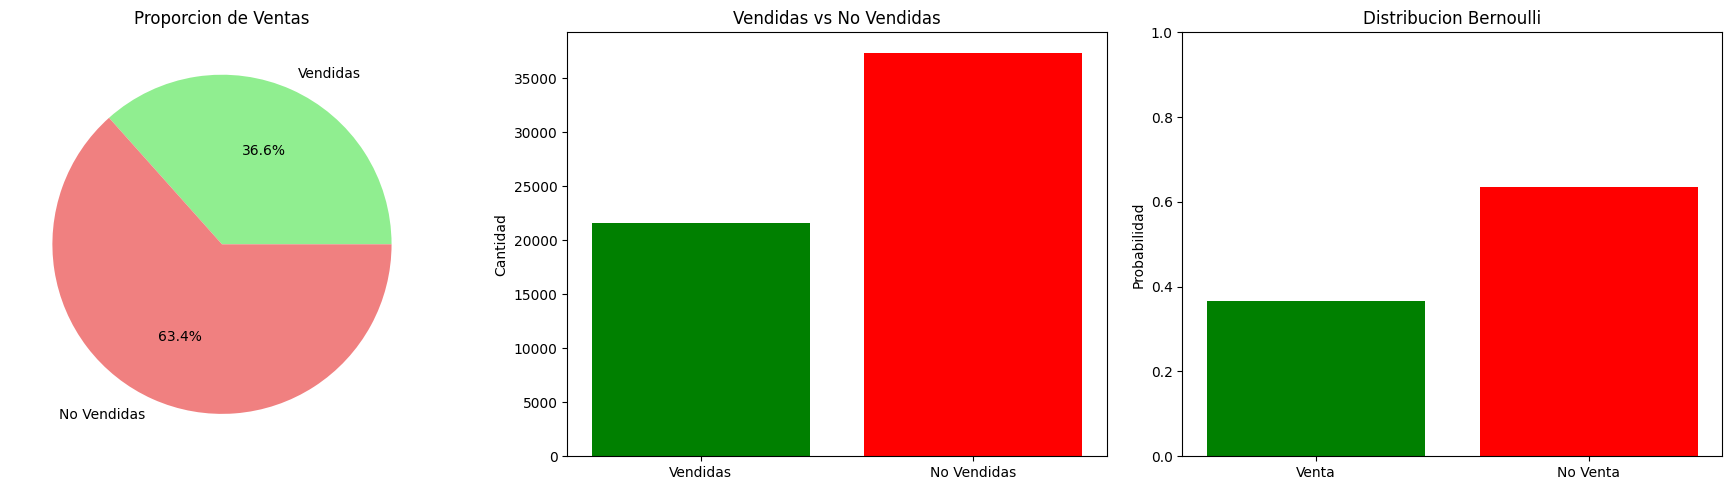

Para simulacion: Bernoulli con p = 0.3660


In [89]:
# VISUALIZACION: Probabilidad de Venta por propiedad
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grafico 1: Torta
sizes = [propiedades_vendidas, propiedades_no_vendidas]
labels = ['Vendidas', 'No Vendidas']
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[0].set_title('Proporcion de Ventas')

# Grafico 2: Barras cantidad
axes[1].bar(labels, sizes, color=['green', 'red'])
axes[1].set_ylabel('Cantidad')
axes[1].set_title('Vendidas vs No Vendidas')

# Grafico 3: Bernoulli (probabilidades)
prob_venta = porcentaje_vendidas / 100
axes[2].bar(['Venta', 'No Venta'], [prob_venta, 1-prob_venta], color=['green', 'red'])
axes[2].set_ylabel('Probabilidad')
axes[2].set_title('Distribucion Bernoulli')
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"Para simulacion: Bernoulli con p = {prob_venta:.4f}")

In [92]:
# 📊 PROBABILIDAD DE VENTA POR VISITA
# =========================================================================

# Solo considerar propiedades vendidas (que tienen contactos)
propiedades_vendidas_con_contactos = propiedades[
    (propiedades['fecha_venta'].notna()) & 
    (propiedades['contactos'] > 0)
]

# Total de contactos recibidos por propiedades vendidas
total_contactos_vendidas = propiedades_vendidas_con_contactos['contactos'].sum()

# Total de ventas exitosas
total_ventas = len(propiedades_vendidas_con_contactos)

# Probabilidad de venta POR VISITA
prob_venta_por_visita = total_ventas / total_contactos_vendidas

print("="*80)
print("COMPARACIÓN: Probabilidad por PROPIEDAD vs por VISITA")
print("="*80)

print(f"\n1️⃣  PROBABILIDAD POR PROPIEDAD:")
print(f"    De todas las propiedades publicadas, ¿cuántas se venden?")
print(f"    P(Venta | Propiedad) = {porcentaje_vendidas/100:.4f} ({porcentaje_vendidas:.2f}%)")
print(f"    Uso: Para decidir si una propiedad se venderá eventualmente")

print(f"\n2️⃣  PROBABILIDAD POR VISITA:")
print(f"    De cada visita individual, ¿cuántas resultan en venta?")
print(f"    P(Venta | Visita) = {prob_venta_por_visita:.6f} ({prob_venta_por_visita*100:.4f}%)")
print(f"    Uso: Para decidir si una visita específica resulta en venta")

# Interpretación
contactos_promedio_hasta_venta = propiedades_vendidas_con_contactos['contactos'].mean()

print(f"\n📊 INTERPRETACIÓN:")
print(f"    • En promedio, una propiedad necesita {contactos_promedio_hasta_venta:.1f} visitas para venderse")
print(f"    • Por tanto, cada visita tiene ~{prob_venta_por_visita*100:.4f}% de probabilidad de resultar en venta")
print(f"    • O sea: 1 de cada {int(1/prob_venta_por_visita)} visitas resulta en venta")

print("\n" + "="*80)
print("🎯 PARA TU SIMULACIÓN:")
print("="*80)
print("\n💡 OPCIÓN A - Modelo simple:")
print(f"    Por cada visita: U ~ Uniform(0,1)")
print(f"    Si U < {prob_venta_por_visita:.6f} → VENTA")

print("\n💡 OPCIÓN B - Modelo realista:")
print(f"    1. Determinar si propiedad se venderá: U < {porcentaje_vendidas/100:.4f}")
print(f"    2. Si SÍ, generar número de visitas necesarias ~ Geométrica(p={prob_venta_por_visita:.6f})")
print("="*80)

COMPARACIÓN: Probabilidad por PROPIEDAD vs por VISITA

1️⃣  PROBABILIDAD POR PROPIEDAD:
    De todas las propiedades publicadas, ¿cuántas se venden?
    P(Venta | Propiedad) = 0.3660 (36.60%)
    Uso: Para decidir si una propiedad se venderá eventualmente

2️⃣  PROBABILIDAD POR VISITA:
    De cada visita individual, ¿cuántas resultan en venta?
    P(Venta | Visita) = 0.063783 (6.3783%)
    Uso: Para decidir si una visita específica resulta en venta

📊 INTERPRETACIÓN:
    • En promedio, una propiedad necesita 15.7 visitas para venderse
    • Por tanto, cada visita tiene ~6.3783% de probabilidad de resultar en venta
    • O sea: 1 de cada 15 visitas resulta en venta

🎯 PARA TU SIMULACIÓN:

💡 OPCIÓN A - Modelo simple:
    Por cada visita: U ~ Uniform(0,1)
    Si U < 0.063783 → VENTA

💡 OPCIÓN B - Modelo realista:
    1. Determinar si propiedad se venderá: U < 0.3660
    2. Si SÍ, generar número de visitas necesarias ~ Geométrica(p=0.063783)


/tmp/ipykernel_30066/178954088.py:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_30066/178954088.py:28: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


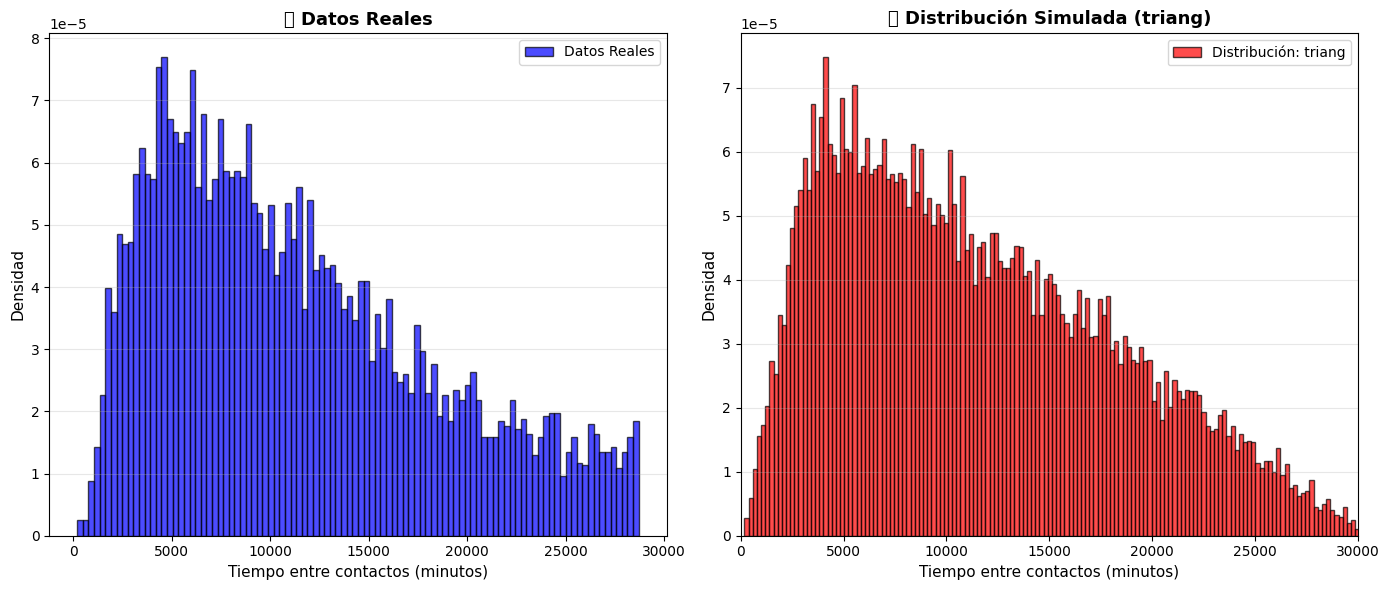

In [93]:
# 📊 PASO 3: Verifica tu histograma simulado vs el real
#
# Compara visualmente qué tan bien tu distribución se ajusta a los datos reales

plt.figure(figsize=(14, 6))

# Subplot 1: Datos REALES
plt.subplot(1, 2, 1)
plt.hist(datos_tiempo_contactos, bins=100, density=True, alpha=0.7, 
         color='blue', edgecolor='black', label='Datos Reales')
plt.xlabel('Tiempo entre contactos (minutos)', fontsize=11)
plt.ylabel('Densidad', fontsize=11)
plt.title('📊 Datos Reales', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Datos SIMULADOS (con tu distribución)
plt.subplot(1, 2, 2)
plt.hist(fdp_f, bins=150, density=True, alpha=0.7, 
         color='red', edgecolor='black', label=f'Distribución: {distribucion_elegida}')
plt.xlabel('Tiempo entre contactos (minutos)', fontsize=11)
plt.ylabel('Densidad', fontsize=11)
plt.title(f'🎲 Distribución Simulada ({distribucion_elegida})', fontsize=13, fontweight='bold')
plt.xlim(0, 30000)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()